In [1]:
%matplotlib inline

# tikreg tutorial: Non-spherical multivariate normal priors on features

`tikreg`: https://github.com/gallantlab/tikreg

This example follows Figure 1 from [Nunez-Elizalde, et al., 2019.](https://www.sciencedirect.com/science/article/pii/S1053811919302988?via%3Dihub)

We'll be using data from a language experiment (Huth, et al., 2016). 
For a lot more detail on the semantic model used in this experiment, please refer to this tutorial: https://github.com/HuthLab/speechmodeltutorial/blob/master/SpeechModelTutorial.ipynb

## Download the data

In addition to `tikreg`, you'll need to install `h5py` to load the example data used in this tutorial.

Uncomment the following line install the requirements:

In [2]:
#!pip install tikreg==0.0.1 h5py

Get the data from this link (~250MB): https://drive.google.com/open?id=1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj.

Once downloaded, unzip the file contents and write the location:

In [3]:
# Location of the unzipped data
root_directory = '.' # defaults to current working directory

In [4]:
## On linux (and maybe macs), you can use the following to download and unzip the data
## (from: https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805#gistcomment-2316906)

if 0: # Change to 1 if running on e.g. Binder or Google Colab
    import os
    flname = 'tikreg_demodata.zip'
    unzipped_folder = 'tiny_language'
    cmd = r'''wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf /tmp/cookies.txt'''
    if not os.path.exists(flname) and not os.path.exists(unzipped_folder):
        os.system(cmd.format(FILEID='1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj',FILENAME=flname))
    os.system('unzip -u tikreg_demodata.zip')

## Start

In [5]:
import os

import numpy as np
np.random.seed(1337)
np.set_printoptions(precision=4, suppress=True)

from scipy.stats import zscore
from matplotlib import pyplot as plt
plt.style.use('default')

import h5py
from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

In [6]:
path = os.path.join(root_directory, 'tiny_language')
features_file = os.path.join(path, 'features', 'words.hdf')
priors_file = os.path.join(path, 'priors', 'feature_priors.hdf')
responses_file = os.path.join(path, 'responses', 'S1.hdf')

We first define a couple of helper functions for loading and plotting the data

In [7]:
def hdf_load(hdf_file, key):
    '''Load data from an HDF5 file
    '''
    assert os.path.exists(hdf_file)
    
    with h5py.File(hdf_file, 'r') as hfl:
        hdf_content = hfl.keys()
        assert key in hdf_content
        return np.asarray(hfl[key])
    

def plot_model_2dhist_comparison(corrs1, corrs2, 
                                 name1='corrs1', name2='corrs2', cmap='inferno',
                                 ax=None, lims=(-0.5, 1.0), nbins=100, 
                                 title='model comparison\n(prediction accuracy [$r$])'):
    '''Histogram of prediction accuracy from two models
    
    Parameters
    ----------
    corrs1, corrs2 : np.ndarray (N,)
        Data to plot along the horizontal (corrs1) and vertical (corrs2) dimension
    '''
    colormap = plt.cm.get_cmap(cmap)
    
    lo, hi = lims
    bins = np.linspace(lo, hi, nbins)
    h, xe, ye = np.histogram2d(corrs2,
                               corrs1,
                               bins=bins)

    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

    im = ax.imshow(np.log(h), origin="lower", extent=(lo, hi, lo, hi), cmap=colormap, interpolation='nearest')
    ax.plot([lo, hi], [lo, hi], 'k-')
    ax.axis([lo, hi, lo, hi])


    ax.plot([0, 0], [lo, hi], color="0.1", linestyle=":")
    ax.plot([lo, hi], [0, 0], color="0.1", linestyle=":")

    ax.set_ylabel("%s model" % name2, fontsize=15)
    ax.set_xlabel("%s model" % name1, fontsize=15)

    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label('voxel density [$log_{10}$]', fontsize=15)
    _ = ax.set_title(title, fontsize=20)
    return ax


def symmatshow(mat, ax=None, cbar=True, cmap='coolwarm', **kwargs):
    '''Display a matrix with values centered at zero
    '''
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
                         
    matmin = np.nanmin(mat)
    matmax = np.nanmax(mat)
    vmax = np.max([np.abs(matmin), np.abs(matmax)])
    im = ax.matshow(mat, cmap=cmap, vmin=-vmax, vmax=vmax, **kwargs)
    if cbar:
        cb = plt.colorbar(im, orientation='vertical')
    return ax

### Load data

In [8]:
Xtrain = hdf_load(features_file, 'train')
Xtest = hdf_load(features_file, 'test')
print(Xtrain.shape, Xtest.shape)

(3737, 3000) (291, 3000)


In [9]:
Ytrain = hdf_load(responses_file, 'train')
Ytest = hdf_load(responses_file, 'test')
print(Ytrain.shape, Ytest.shape)

(3737, 3000) (291, 3000)


In [10]:
semantic_prior = hdf_load(priors_file, 'semantic_prior')
print(semantic_prior.shape)

(3000, 3000)


In [11]:
nfeatures = Xtrain.shape[1]
delays = np.asarray([1,2,3,4])

In [12]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

### Fit models

We first fit a standard ridge regression model using `tikreg`.

In [13]:
fit_spherical = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                           [Xtest],Ytest,
                                           feature_priors=[feature_prior],
                                           temporal_prior=temporal_prior,
                                           ridges=np.logspace(0,4,10),
                                           folds=(1,5),
                                           population_optimal=True,
                                           performance=True,
                                           chunklen=40,
                                           verbosity=2)

1/1: temporal 1/1=0.000, features 1/1=(1.0000, )
train fold  1/5: ntrain=2977, ntest=760
lambda 01:    1.000, mean=0.0472, (25,50,75)pctl=(0.0043,0.0421,0.0837),(0.0<r>0.5): (2327,000)
lambda 02:    2.783, mean=0.0600, (25,50,75)pctl=(0.0091,0.0521,0.1018),(0.0<r>0.5): (2404,000)
lambda 03:    7.743, mean=0.0716, (25,50,75)pctl=(0.0137,0.0590,0.1182),(0.0<r>0.5): (2458,000)
lambda 04:   21.544, mean=0.0709, (25,50,75)pctl=(0.0118,0.0592,0.1179),(0.0<r>0.5): (2443,000)
lambda 05:   59.948, mean=0.0655, (25,50,75)pctl=(0.0103,0.0548,0.1118),(0.0<r>0.5): (2418,000)
lambda 06:  166.810, mean=0.0636, (25,50,75)pctl=(0.0098,0.0536,0.1100),(0.0<r>0.5): (2406,000)
lambda 07:  464.159, mean=0.0633, (25,50,75)pctl=(0.0099,0.0532,0.1096),(0.0<r>0.5): (2404,000)
lambda 08: 1291.550, mean=0.0633, (25,50,75)pctl=(0.0099,0.0531,0.1096),(0.0<r>0.5): (2403,000)
lambda 09: 3593.814, mean=0.0633, (25,50,75)pctl=(0.0099,0.0531,0.1095),(0.0<r>0.5): (2403,000)
lambda 10: 10000.000, mean=0.0633, (25,50,75)pc

/home/anunez/.local/lib/python3.6/site-packages/tikreg/models.py:1178: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  unique_optima = np.vstack(set(tuple(row) for row in optima)) # get unique rows


lambda 01:   21.544, mean=0.1570, (25,50,75)pctl=(0.0813,0.1514,0.2260),(0.0<r>0.5): (2872,000)
3000 responses: ridge=   21.544, temporal=0.000, spatial=(1.000) perf=0.1570
Total duration 0.4669[mins]


We next use the semantic prior to estimate a new model.

In [14]:
feature_prior = spatial_priors.CustomPrior(semantic_prior)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

Text(0.5, 1.05, 'semantic prior')

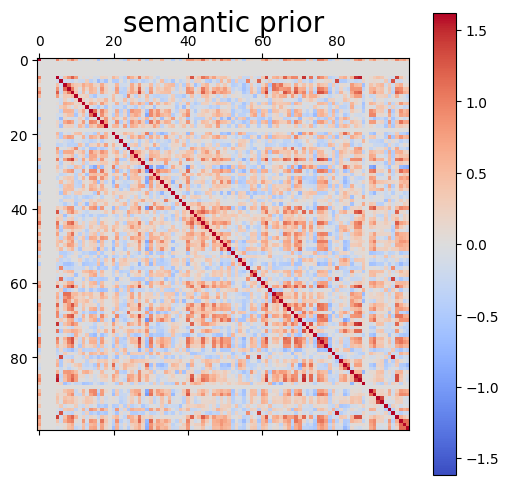

In [15]:
ax = symmatshow(feature_prior.get_prior()[:100,:100])
ax.set_title('semantic prior', fontsize=20)

In [16]:
fit_nonspherical = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                              [Xtest],Ytest,
                                              feature_priors=[feature_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=np.logspace(0,4,10),
                                              folds=(1,5),
                                              performance=True,
                                              population_optimal=True,
                                              chunklen=40,
                                              verbosity=2)

1/1: temporal 1/1=0.000, features 1/1=(1.0000, )
train fold  1/5: ntrain=2977, ntest=760
lambda 01:    1.000, mean=0.0290, (25,50,75)pctl=(-0.0097,0.0225,0.0598),(0.0<r>0.5): (2038,000)
lambda 02:    2.783, mean=0.0556, (25,50,75)pctl=(0.0008,0.0406,0.0947),(0.0<r>0.5): (2271,000)
lambda 03:    7.743, mean=0.0812, (25,50,75)pctl=(0.0086,0.0601,0.1413),(0.0<r>0.5): (2383,000)
lambda 04:   21.544, mean=0.0884, (25,50,75)pctl=(0.0133,0.0703,0.1547),(0.0<r>0.5): (2425,000)
lambda 05:   59.948, mean=0.0808, (25,50,75)pctl=(0.0131,0.0649,0.1376),(0.0<r>0.5): (2435,000)
lambda 06:  166.810, mean=0.0688, (25,50,75)pctl=(0.0080,0.0508,0.1179),(0.0<r>0.5): (2383,000)
lambda 07:  464.159, mean=0.0613, (25,50,75)pctl=(0.0059,0.0444,0.1073),(0.0<r>0.5): (2349,000)
lambda 08: 1291.550, mean=0.0597, (25,50,75)pctl=(0.0050,0.0434,0.1044),(0.0<r>0.5): (2339,000)
lambda 09: 3593.814, mean=0.0595, (25,50,75)pctl=(0.0048,0.0434,0.1040),(0.0<r>0.5): (2337,000)
lambda 10: 10000.000, mean=0.0594, (25,50,75)p

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


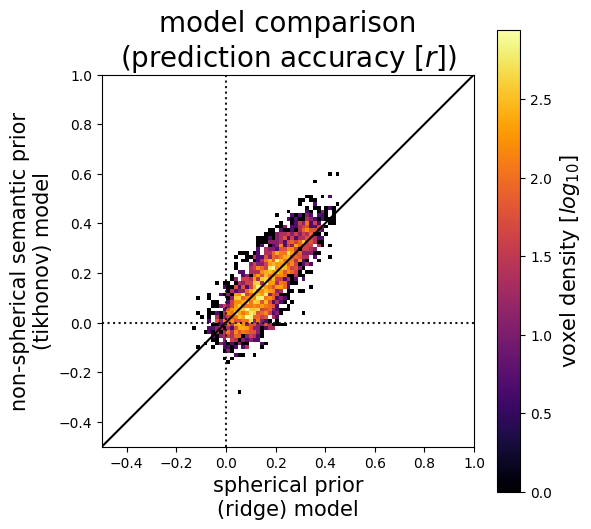

In [17]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_spherical['performance'].squeeze()),
                                  np.nan_to_num(fit_nonspherical['performance'].squeeze()),
                                  'spherical prior\n(ridge)', 'non-spherical semantic prior\n(tikhonov)')